In [108]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import scipy.optimize as optimize
from findiff import FinDiff, coefficients, Coefficient

In [2]:
# SET THE WORKING DIRECTORY
CWD = '/Users/miguel/Documents/Internship_CENTURI'
os.chdir(CWD)

In [3]:
## DEFINES WORKING CONSTANTS
#FILENAME = args.filename
FILENAME = 'gc_wt.csv'
SAVE_FN = FILENAME.strip().split('.')[0]
START = 105 # Start of the linear portion of the graph
ALPH_DICT = {'A':0, 'B':1, 'C':2, 'D':3, 'E':3, 'F':5, 'G':6, 'H':7}

In [4]:
FILE_PATH = os.path.join(os.getcwd(), "data", FILENAME)
df = pd.read_csv(FILE_PATH)

In [110]:
def logistic(x, K, A, C, Q, B, nu):
    '''
        K : carrying capacity
        A : left asymptote
        
    '''
    logistic_den = np.float_power(C + Q * np.exp(-B * x), 1 / nu)
    logistic = (K - A)/ logistic_den + A
    return logistic

In [109]:
def log_lin(x, K, Q, B, nu, m, b):
    '''
        K : carrying capacity
        A : left asymptote
        
    '''
    logistic_den = np.float_power(1 + Q * np.exp(-B * x), 1 / nu)
    logistic = K / logistic_den 
    linear = m * x +  b
    return logistic + linear

In [139]:
X = np.arange(df.shape[0])
y = df['A5'].values
p0 = np.array([1, 0.5, 2, 2e-1, 3e-3, 0], dtype=np.longdouble)
params, cv = optimize.curve_fit(log_lin, X, y, p0, maxfev = 1000000)

/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_24196/1839126831.py:7: RuntimeWarning: overflow encountered in exp
  logistic_den = np.float_power(1 + Q * np.exp(-B * x), 1 / nu)
/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_24196/1839126831.py:7: RuntimeWarning: invalid value encountered in float_power
  logistic_den = np.float_power(1 + Q * np.exp(-B * x), 1 / nu)
/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_24196/1839126831.py:8: RuntimeWarning: divide by zero encountered in divide
  logistic = K / logistic_den
/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_24196/1839126831.py:7: RuntimeWarning: overflow encountered in multiply
  logistic_den = np.float_power(1 + Q * np.exp(-B * x), 1 / nu)
/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_24196/1839126831.py:8: RuntimeWarning: overflow encountered in divide
  logistic = K / logistic_den
/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_24196/1839126831.py:7: Runtim

Let's fit a simple logistic curve to first part of the data to get an estimate of the replication rates

In [388]:
def simple_logistic(x, K, Q, B, nu):
    '''
        K : carrying capacity
        B : growth rate
        
    '''
    logistic_den = np.float_power(1 + Q * np.exp(-B * x), 1 / nu)
    logistic = K / logistic_den
    return logistic

In [94]:
X = np.arange(df.shape[0])
y = df['G2'].values
mean_y = df[df.columns[1:-1]].mean(axis = 1).values
threshold = 100
p0 = (0.4, 2, 2)

In [95]:
#simple_log_params, cv = optimize.curve_fit(simple_logistic, X[:threshold], y[:threshold], p0, maxfev = 100000)
simple_log_params, cv = optimize.curve_fit(simple_logistic, X[:threshold], mean_y[:threshold], p0, maxfev = 100000)

/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_24196/1783425730.py:8: RuntimeWarning: divide by zero encountered in divide
  logistic = K / logistic_den
/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_24196/1783425730.py:8: RuntimeWarning: overflow encountered in divide
  logistic = K / logistic_den
/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_24196/1783425730.py:7: RuntimeWarning: overflow encountered in exp
  logistic_den = np.float_power(1 + np.exp(-B * x), 1 / nu)
/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_24196/1783425730.py:7: RuntimeWarning: overflow encountered in float_power
  logistic_den = np.float_power(1 + np.exp(-B * x), 1 / nu)


In [97]:
simple_log_params

array([0.5518465 , 0.06381521, 0.01729553])

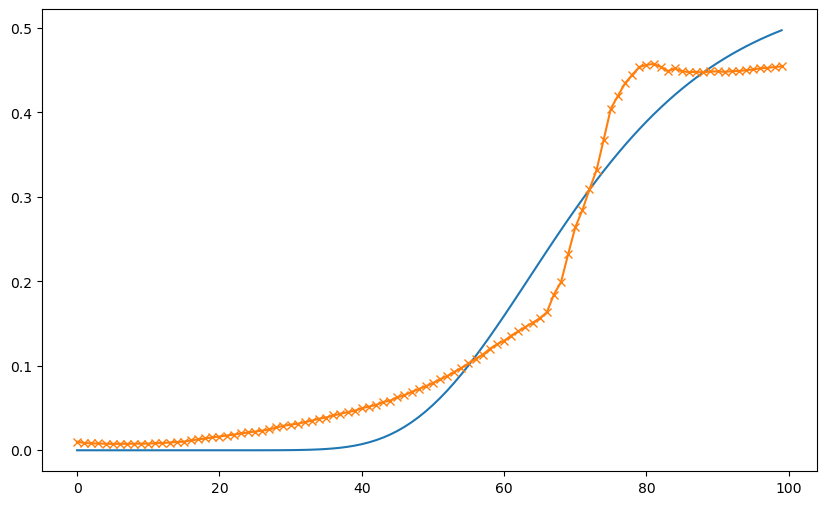

In [98]:
plt.figure(figsize = (10, 6))
plt.plot(X[:threshold], simple_logistic(X[:threshold], *simple_log_params))
#plt.plot(y[:threshold], marker = 'x')
plt.plot(mean_y[:threshold], marker = 'x')

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(X[:threshold], simple_logistic(X[:threshold], *simple_log_params))
#plt.plot(y[:threshold], marker = 'x')
plt.plot(mean_y[:threshold], marker = 'x')

### Fitting the growth curves using the linear + sigmoid functions

In [386]:
def fit_gc(data, func, p0, single_scattering = False):
    # The function fits logistic or logistic + linear function to the growth curves
    # Input is
    # data: dataframe where each column at indices [1:-1] is assumed to be a plate read
    # func: simple_logistic or lin_log
    # p0: initial point for optimization, size must coincide with number of parameters from func
    # single_scattering: considers the single scattering regime, thus discarding all data above 0.4 OD
     
    # For single scattering regime, we take only the OD values les or equal than 0.4
    params = {}
    # Array representing time
    X = np.arange(data.shape[0])
    # Temporary dictionary to store fit parameters
    params_name = []
    if len(p0) == 4:
        params_name = ["K", "Q", "B", "nu"]
    elif len(p0) == 6:
        params_name = ["K", "Q", "B", "nu", "m", "b"]

    for i in data.columns.values[1:-1]:
        # Array with the OD values
        y = data[i].values
        if single_scattering:
            y = y[y <= 0.4]
            X = np.arange(y.shape[0])
        
        # Initial position for optimization, initially using the same for all columns
        # Might be column dependant
        # p0 = np.array([1, 0.5, 2, 2e-1, 3e-3, 0], dtype=np.longdouble)
        temp, cv = optimize.curve_fit(func, X, y, p0, maxfev = 1000000)
        params[i] = dict(zip(params_name, temp))
    
    return params      

In [443]:
def plot_fit_gc(data, func, params, single_scattering = False):
    nrows = len(params) // 2
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize = (20, 6 * nrows), sharex = False)
    #fig.subplots_adjust(hspace=0)
    col = list(params.keys())
    for i, axes in enumerate(ax.flat):
        X = np.arange(data.shape[0])
        y = func(X, *list(params[col[i]].values()))
        
        if single_scattering:
            size = data[data[col[i]] < 0.4].shape[0]
            X = X[:size]
            y = y[:size]
        
        axes.plot(X, y);
        axes.plot(X, data[col[i]].values[:size], 'x-', alpha = 0.5);
        axes.set_title(col[i]);

    plt.show()

In [426]:
test_params = fit_gc(df, simple_logistic, np.array([4e-1, 4e17, 0.5, 4.43]), single_scattering=True)

In [427]:
test_params

{'A5': {'K': 4.1206328887417385,
  'Q': 7.2923404939387e+18,
  'B': 0.39578719609025614,
  'nu': 5.909973849971177},
 'B6': {'K': 4.739397132272375,
  'Q': 6.202910427055884e+19,
  'B': 0.40119325674288314,
  'nu': 6.548581635664388},
 'C7': {'K': 3.73048755114716,
  'Q': 9.211048353169815e+18,
  'B': 0.36655372653477425,
  'nu': 6.082736306582909},
 'D8': {'K': 4.12983281819915,
  'Q': 6.229620429347632e+18,
  'B': 0.351886770099934,
  'nu': 6.569635313418241},
 'E1': {'K': 4.797167231496891,
  'Q': 6.94957388414813e+17,
  'B': 0.376312221224035,
  'nu': 5.088975098129507},
 'E9': {'K': 2.3129665230418515,
  'Q': 3.083066207955714e+18,
  'B': 0.40894970773945877,
  'nu': 6.782856523022035},
 'F10': {'K': 7.279510381217641,
  'Q': 2.6496815955038204e+19,
  'B': 0.35658915671717845,
  'nu': 5.675619747574815},
 'G2': {'K': 1.588068858445073,
  'Q': 3.464121342377299e+19,
  'B': 0.4126681991415552,
  'nu': 7.9011697760903905},
 'G11': {'K': 4.893768615177006,
  'Q': 9.128918773554075e+18

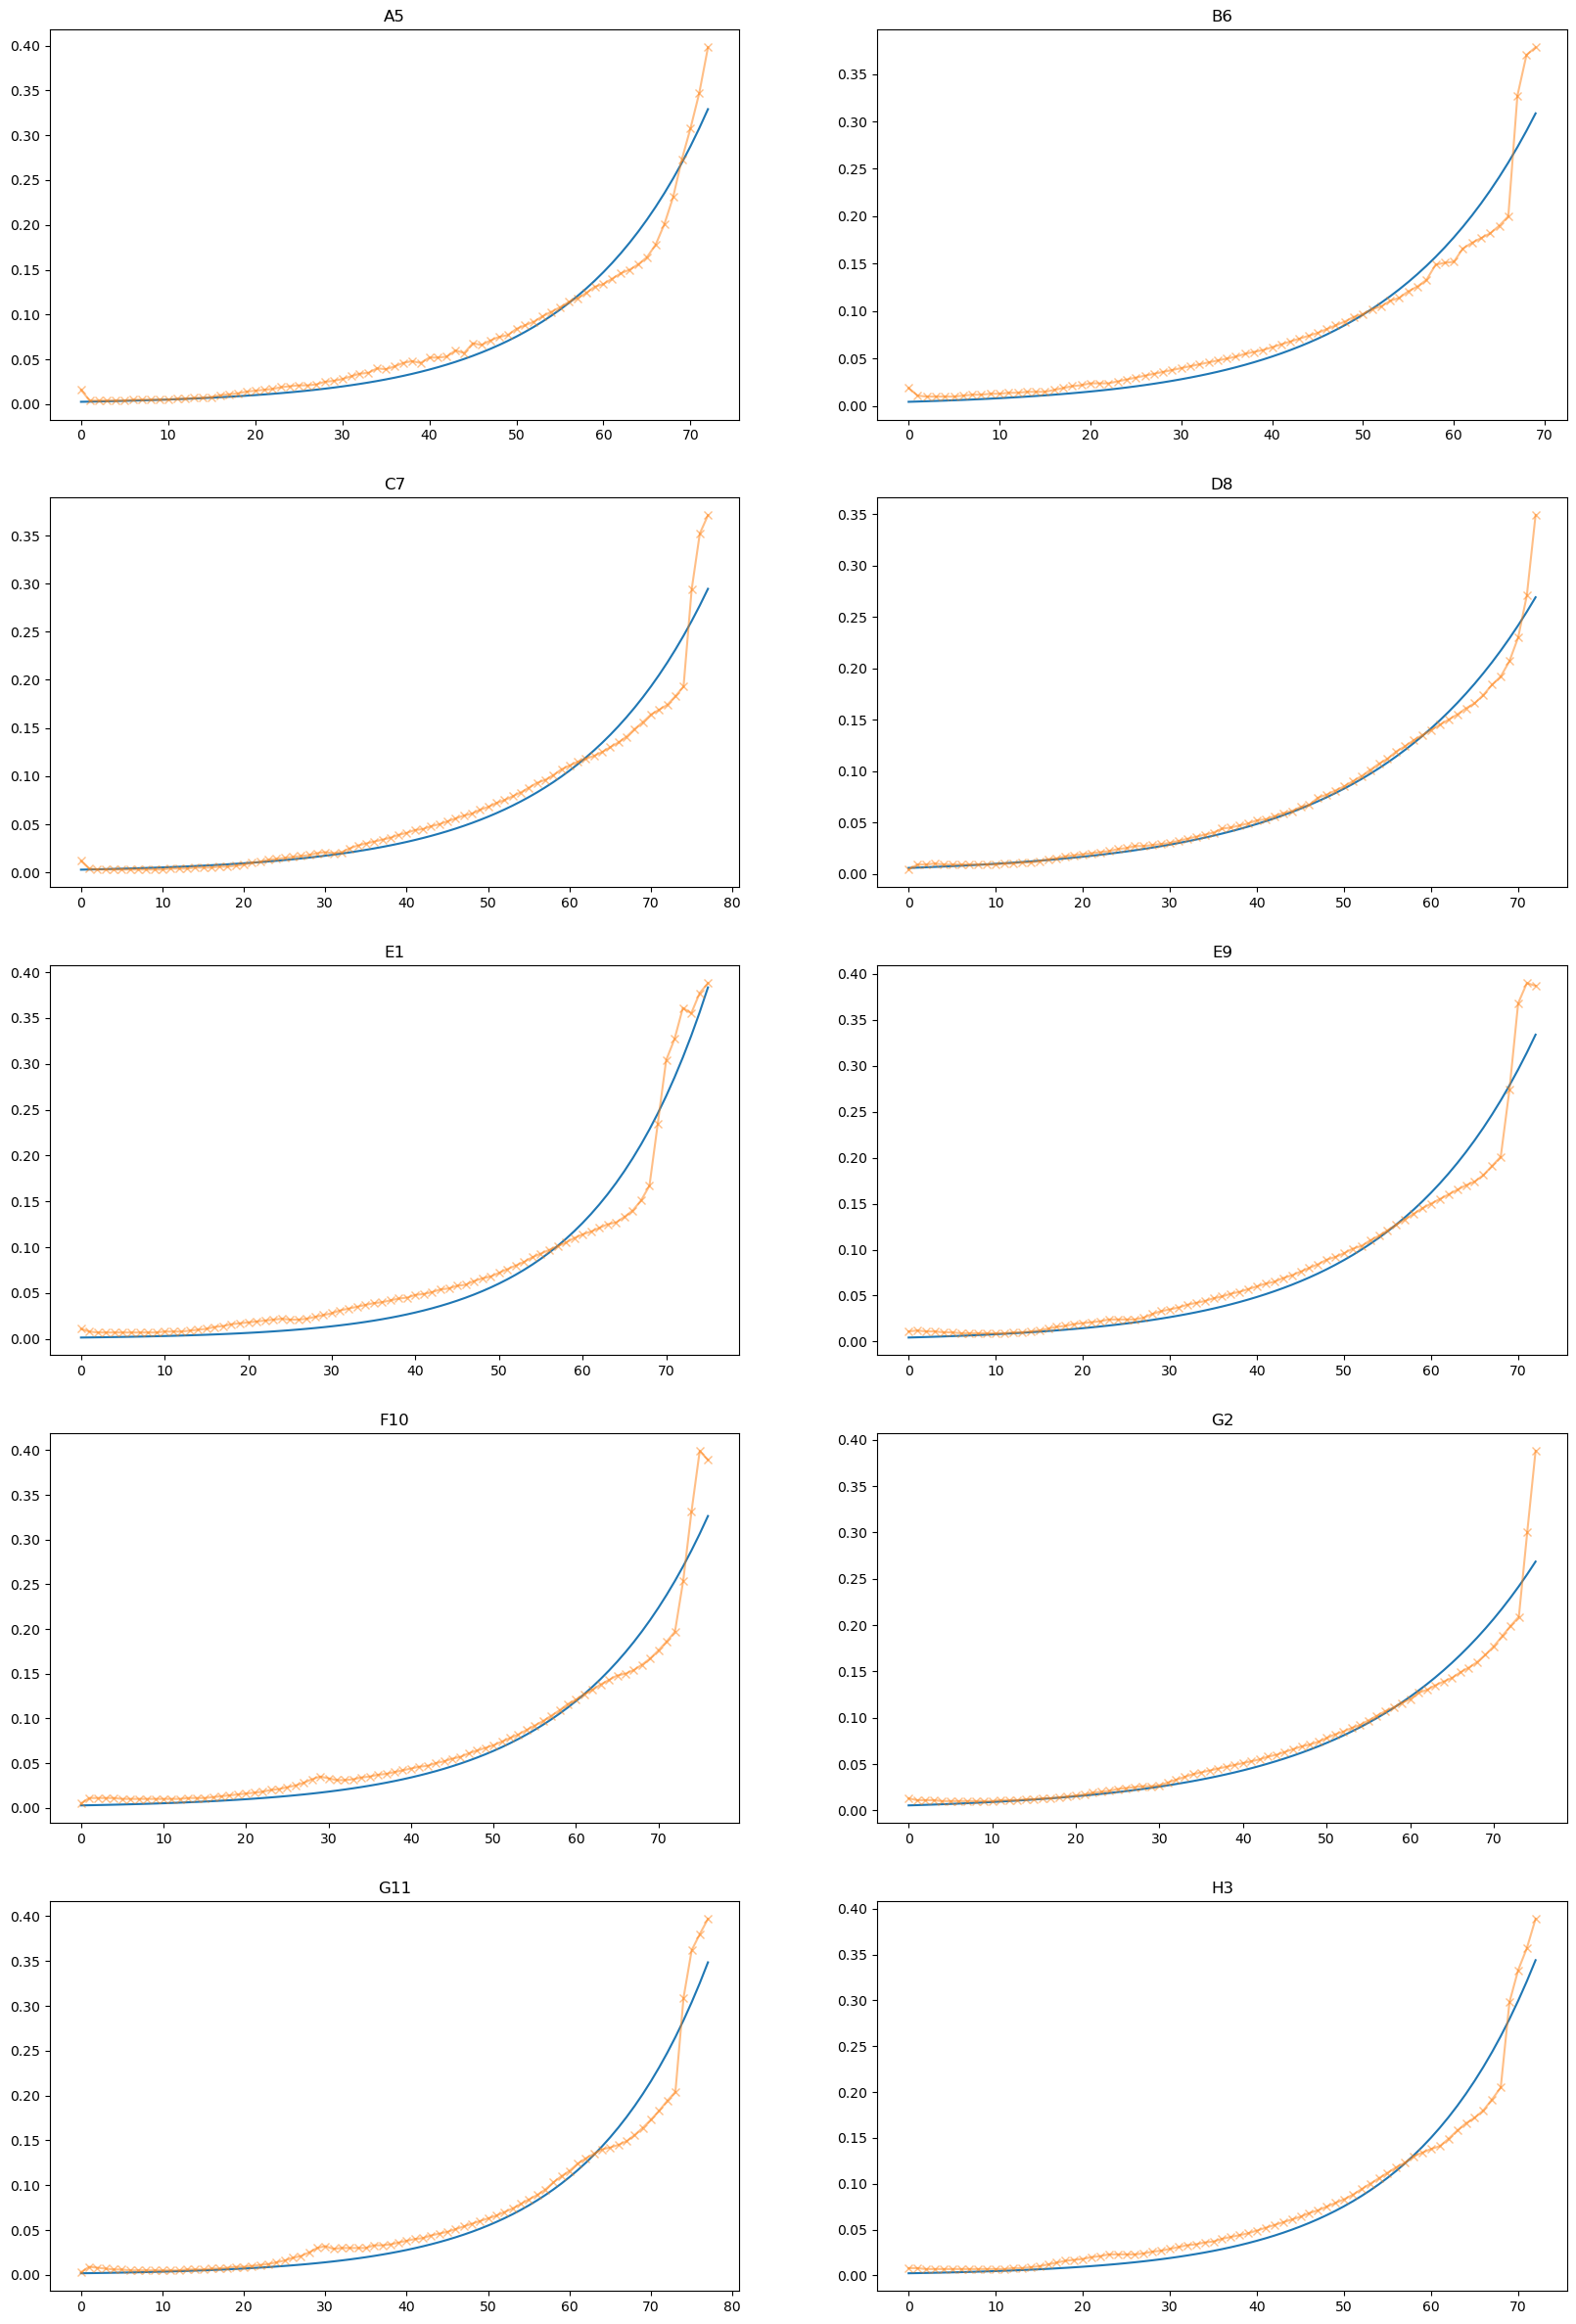

In [444]:
plot_fit_gc(df, simple_logistic, test_params, single_scattering=True)

In [382]:
def fit_lin_log(data, single_scattering = False):
    params = {}
    # Array representing time
    X = np.arange(data.shape[0])
    for i in data.columns.values[1:-1]:
        # Temporary dictionary to store fit parameters
        temp_params = ["K", "Q", "B", "nu", "m", "b"]
        
        # Array with the OD values
        y = data[i].values
        if single_scattering:
            y = y[y <= 0.4]
            X = np.arange(y.shape[0])
        
        # Initial position for optimization, initially using the same for all columns
        # Might be column dependant
        p0 = np.array([1, 0.5, 2, 2e-1, 3e-3, 0], dtype=np.longdouble)
        temp, cv = optimize.curve_fit(log_lin, X, y, p0, maxfev = 1000000)
        params[i] = dict(zip(["K", "Q", "B", "nu", "m", "b"], temp))
    
    return params      


In [383]:
def plot_fit(data, params):
    nrows = len(params) // 2
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize = (20, 6 * nrows), sharex = False)
    #fig.subplots_adjust(hspace=0)
    X = np.arange(data.shape[0])
    for i, axes in enumerate(ax.flat):
        col = list(params.keys())[i]
        axes.plot(log_lin(X, *list(params[col].values())))
        axes.plot(X, df[col], 'x-', alpha = 0.5)
        axes.set_title(col);



    

In [318]:
params = fit_lin_log(df[1:-1])

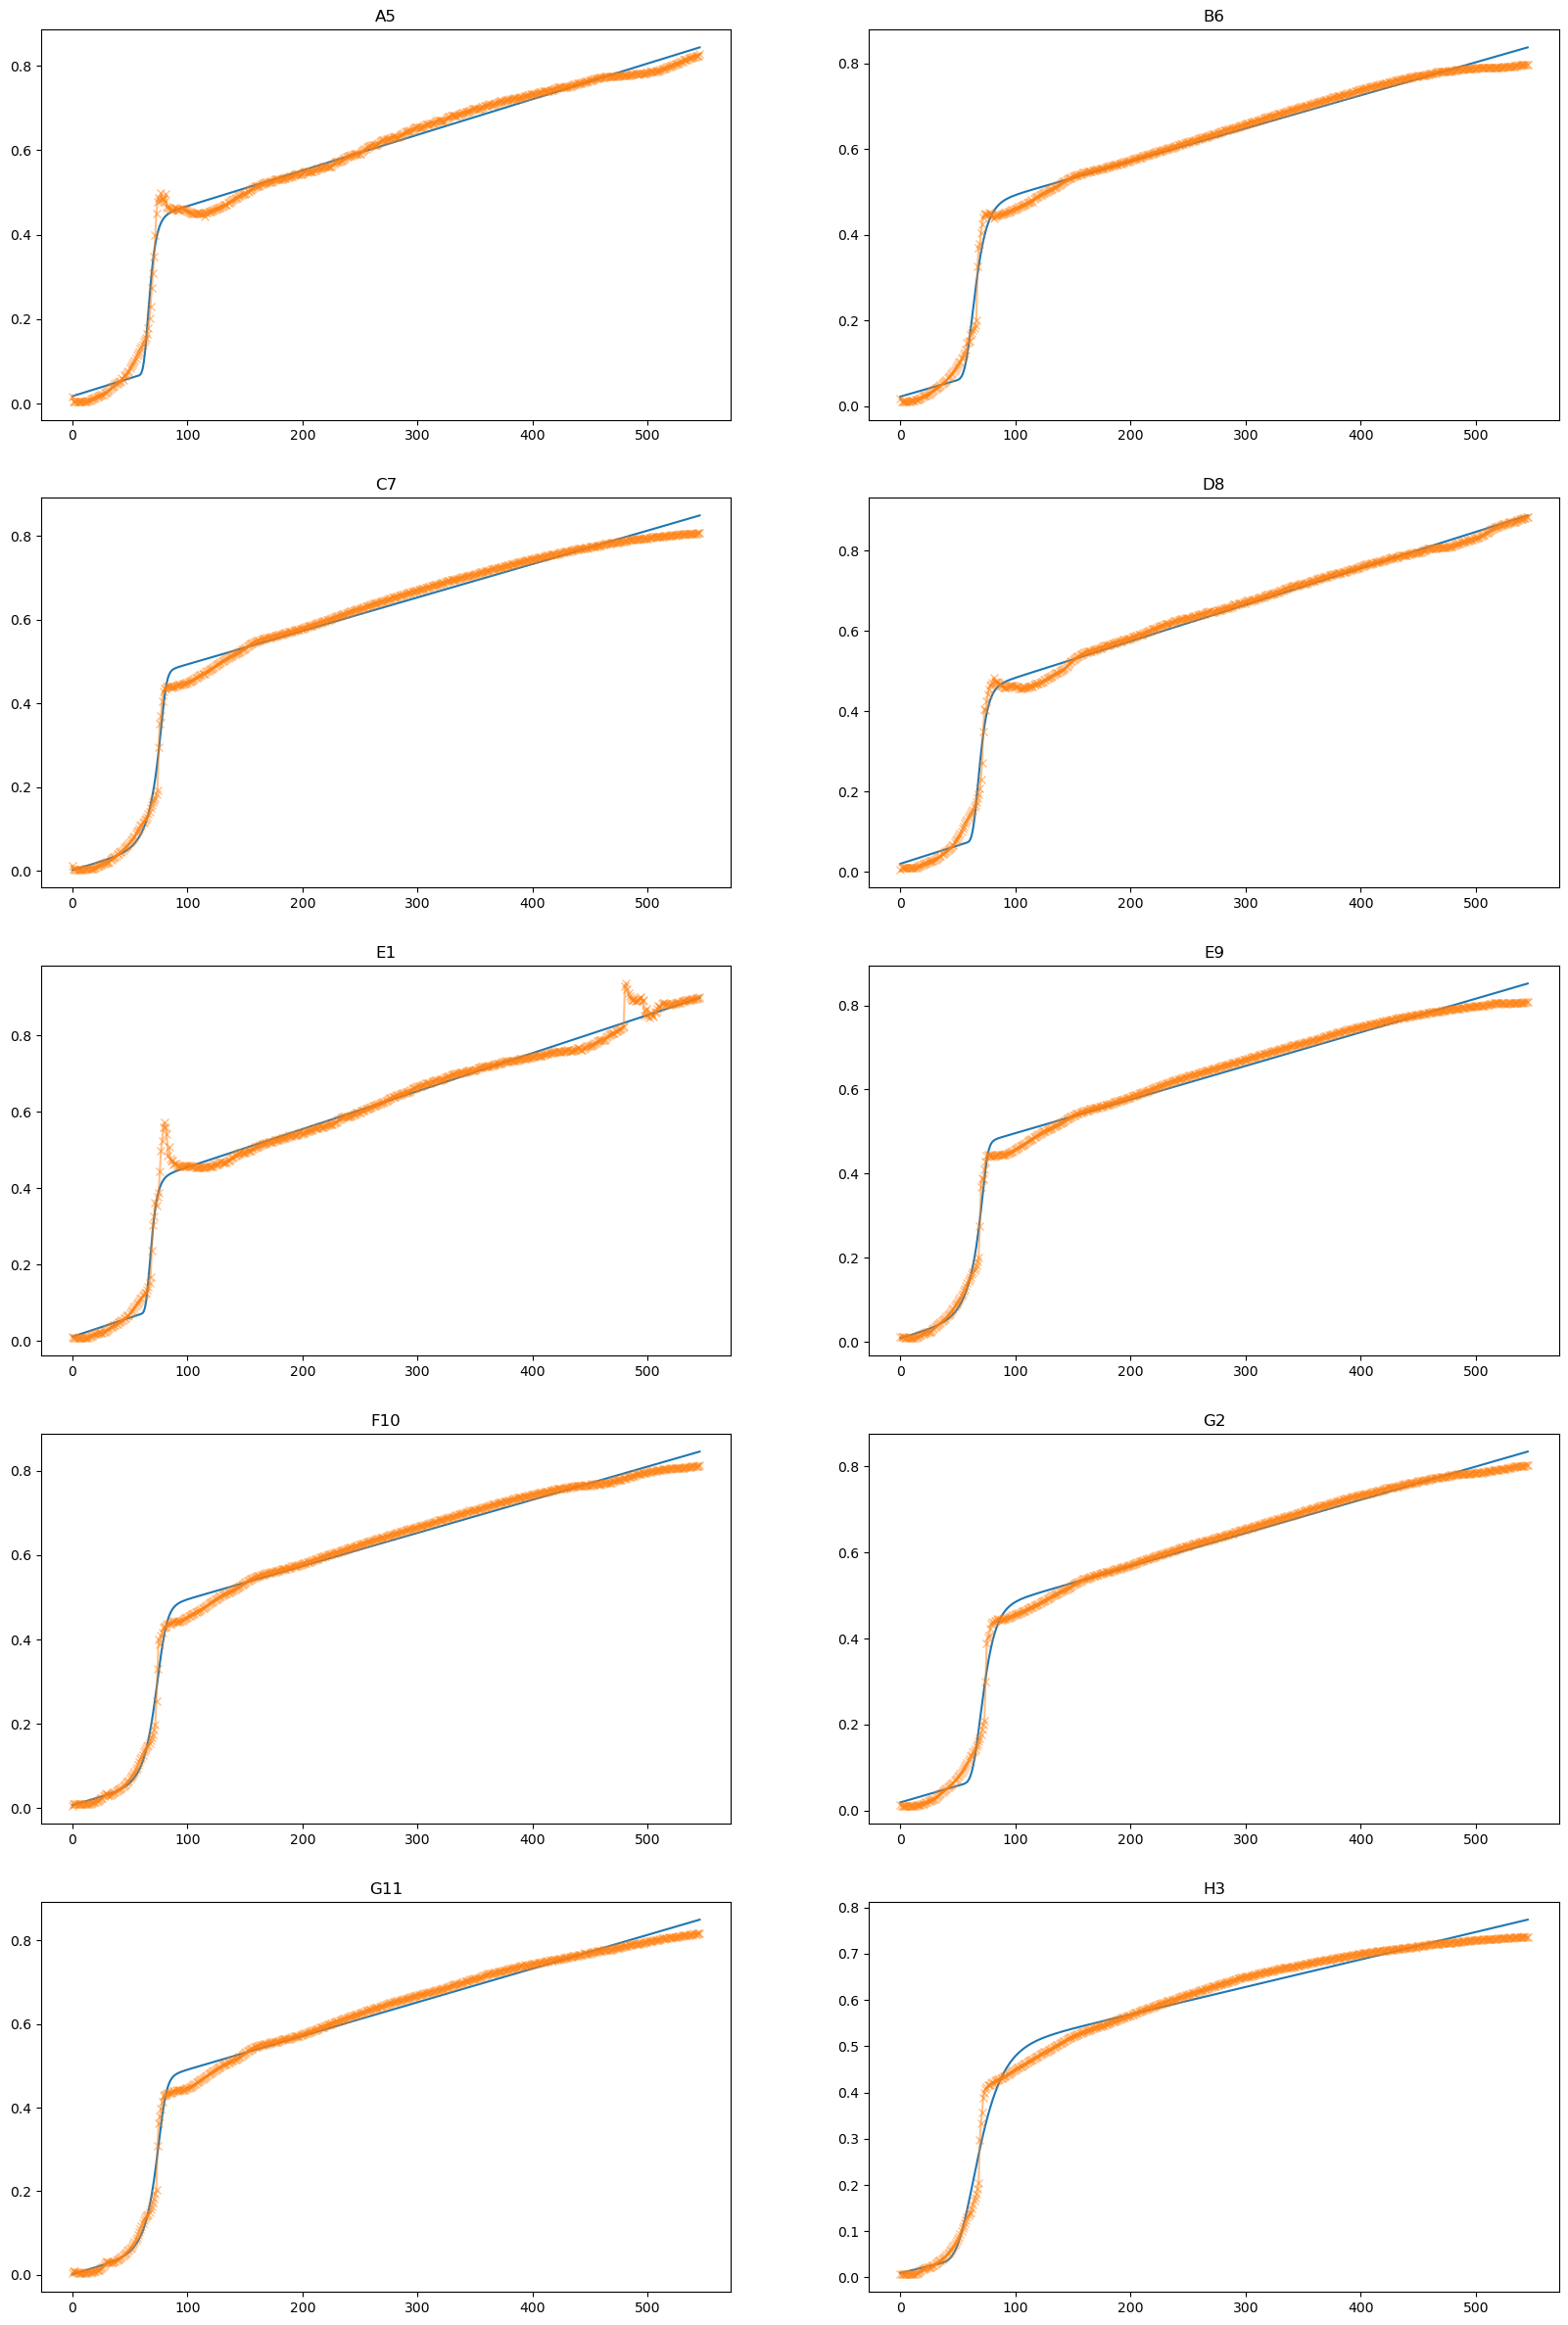

In [319]:

plot_fit(params)

In [247]:
# Uncomment if need to save the parameters again
#pd.DataFrame(params).to_csv(CWD + '/data/fit_gc_wt.csv')

Run the fit with my defined function for the mutant types

In [369]:
serCGA_path = os.path.join(CWD, "data/gc_delserCGA.csv")
serCGA_df = pd.read_csv(serCGA_path)

In [370]:
serCGA_params = fit_lin_log(serCGA_df[1:-1])

In [372]:
# Uncomment if need to save the parameters again
# pd.DataFrame(serCGA_params).to_csv(CWD + '/data/fit_gc_delserCGA.csv')

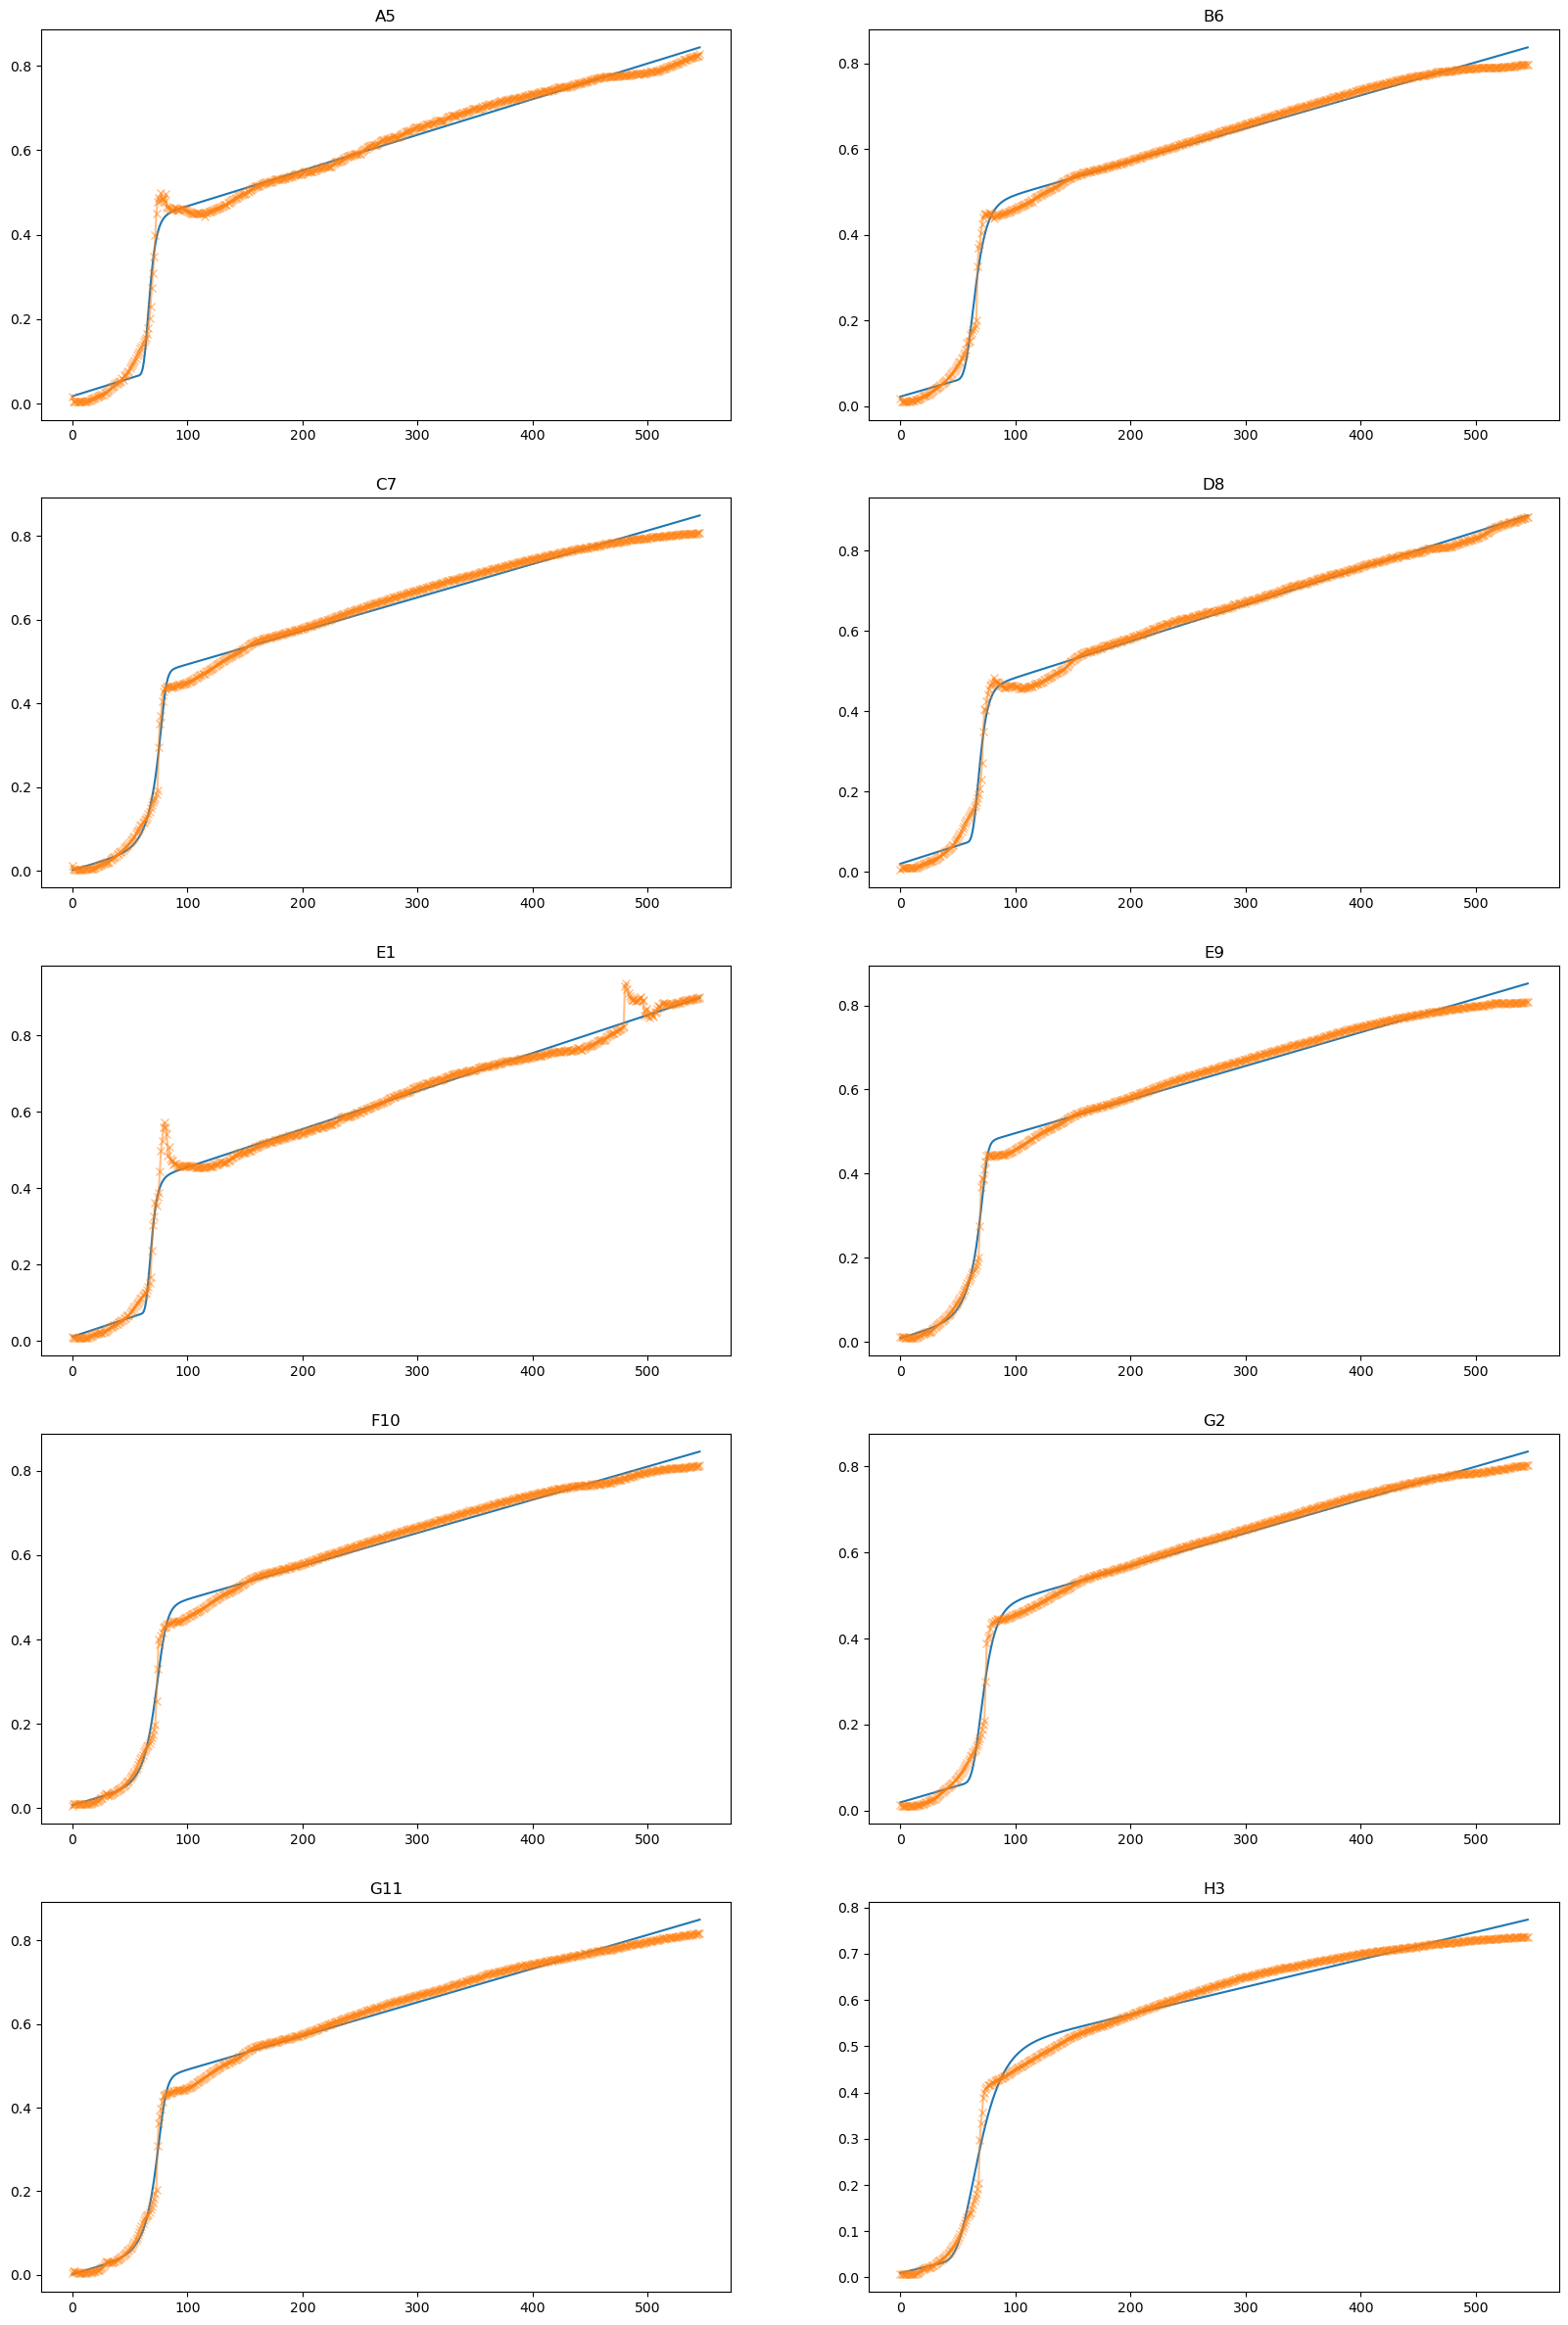

In [371]:
plot_fit(serCGA_params)

Let's try the fit with the lmfit library which returns confidence intervals as well


In [324]:
from lmfit.models import ExpressionModel, StepModel, LinearModel
import lmfit

  logistic_den = K/np.float_power(1 + Q * np.exp(-B * x), 1 / nu)
    logistic = K / logistic_den 

In [302]:
gmodel1 = StepModel(form = 'logistic') + LinearModel()

In [305]:
result1 = gmodel1.fit(y, x=X)

In [304]:
gmodel1.param_names

['amplitude', 'center', 'sigma', 'slope', 'intercept']

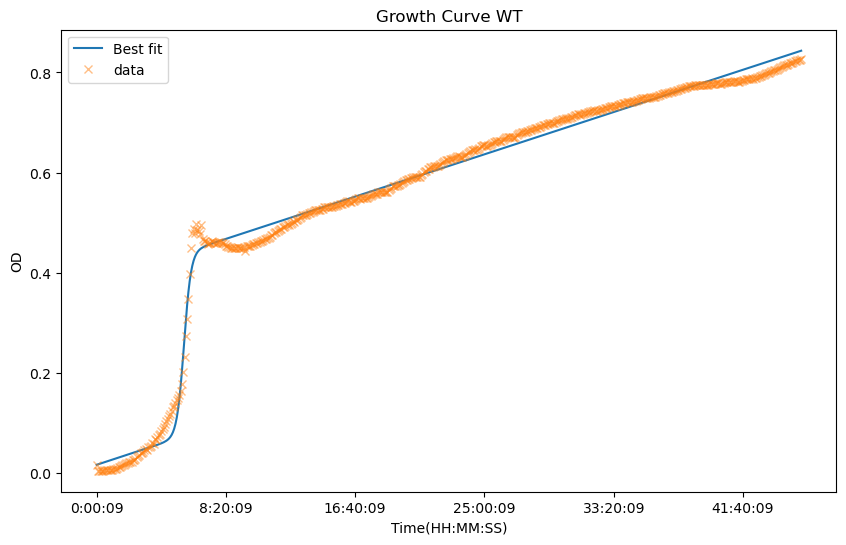

In [342]:
plt.figure(figsize = (10,6))
#plt.plot(X, result1.init_fit, '--', label='initial fit')
#plt.plot(X, result.best_fit, '-', label='best fit')
plt.plot(X, result1.best_fit, '-', label='Best fit')
plt.plot(X, y, 'x', alpha = 0.5, label = 'data')
plt.legend();
plt.xticks(np.arange(0,501,100),list(df['Time'].values[np.arange(0,501,100)]));
plt.xlabel('Time(HH:MM:SS)');
plt.ylabel('OD');
plt.title('Growth Curve WT');
plt.savefig('gc_fit.png', dpi = 300);

In [307]:
print(result1.fit_report())

[[Model]]
    (Model(step, form='logistic') + Model(linear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 520
    # data points      = 546
    # variables        = 5
    chi-square         = 0.15936017
    reduced chi-square = 2.9457e-04
    Akaike info crit   = -4434.00725
    Bayesian info crit = -4412.49416
    R-squared          = 0.99422309
[[Variables]]
    amplitude:  0.36699806 +/- 0.00294170 (0.80%) (init = 1)
    center:     67.5745612 +/- 0.19817883 (0.29%) (init = 0)
    sigma:      2.72752872 +/- 0.17385996 (6.37%) (init = 1)
    slope:      8.4503e-04 +/- 5.8772e-06 (0.70%) (init = 1)
    intercept:  0.01585602 +/- 0.00225557 (14.23%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, intercept) = -0.7352
    C(amplitude, slope)     = -0.5802
    C(amplitude, sigma)     = +0.2864
    C(center, intercept)    = +0.2592
    C(sigma, intercept)     = -0.2156
    C(sigma, slope)         = -0.1592
    C(center, slo

In [321]:
result1.best_values

{'slope': 0.0008450307677808628,
 'intercept': 0.01585602061888991,
 'form': 'logistic',
 'amplitude': 0.36699806227738974,
 'center': 67.57456118636935,
 'sigma': 2.727528722736964}

In [322]:
def lmfit_lin_log(data):
    result = {}
    # Array representing time
    X = np.arange(df.shape[0])
    for i in df.columns.values[1:-1]:
        gmodel = StepModel(form = 'logistic') + LinearModel()
        # Array with the OD values
        y = df[i].values
        
        # Initial position for optimization, initially using the same for all columns
        # Might be column dependant
        temp_result = gmodel.fit(y, x=X)
        result[i] = temp_result
    
    return result

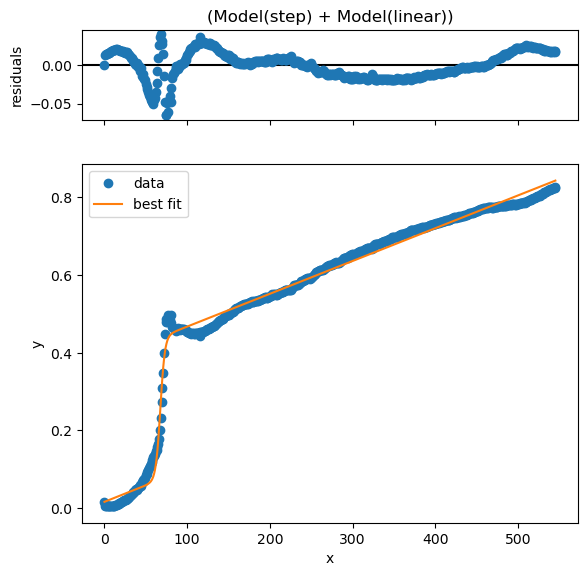

In [328]:
lmfit_lin_log(df)['A5'].plot();

In [345]:
test =lmfit_lin_log(df)

In [362]:
test

{'A5': <lmfit.model.ModelResult at 0x280d853f0>,
 'B6': <lmfit.model.ModelResult at 0x280d848b0>,
 'C7': <lmfit.model.ModelResult at 0x280d67430>,
 'D8': <lmfit.model.ModelResult at 0x280d86f50>,
 'E1': <lmfit.model.ModelResult at 0x280d642b0>,
 'E9': <lmfit.model.ModelResult at 0x280d64fd0>,
 'F10': <lmfit.model.ModelResult at 0x281a2f6d0>,
 'G2': <lmfit.model.ModelResult at 0x280d85bd0>,
 'G11': <lmfit.model.ModelResult at 0x280d67e80>,
 'H3': <lmfit.model.ModelResult at 0x280d660e0>}

In [357]:
results_dict ={}
for i in ['gc_delserCGA.csv', 'gc_wt.csv']:
    temp_fn = i
    save_fn = i.strip().split('.')[0]
    temp_path = os.path.join(CWD, "data", temp_fn)

    temp_df = pd.read_csv(temp_path)
    X = np.arange(temp_df.shape[0])
    temp_dict = {}
    for j in temp_df.columns[1:-1]:
        y = temp_df[j].values
        
        gmodel = StepModel(form = 'logistic') + LinearModel()
        result = gmodel.fit(y, x = X)
        temp_dict[j] = result.best_values
    
    results_dict[save_fn] = temp_dict

In [360]:
for i in results_dict.keys():
    pd.DataFrame(results_dict[i]).to_csv('param_{}.csv'.format(i))

Because the OD above 0.4 enters the region of multiple scattering, let's work with the data below 0.4


In [378]:
new_params = fit_lin_log(df, single_scattering = True)

/Users/miguel/anaconda3/envs/trna/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


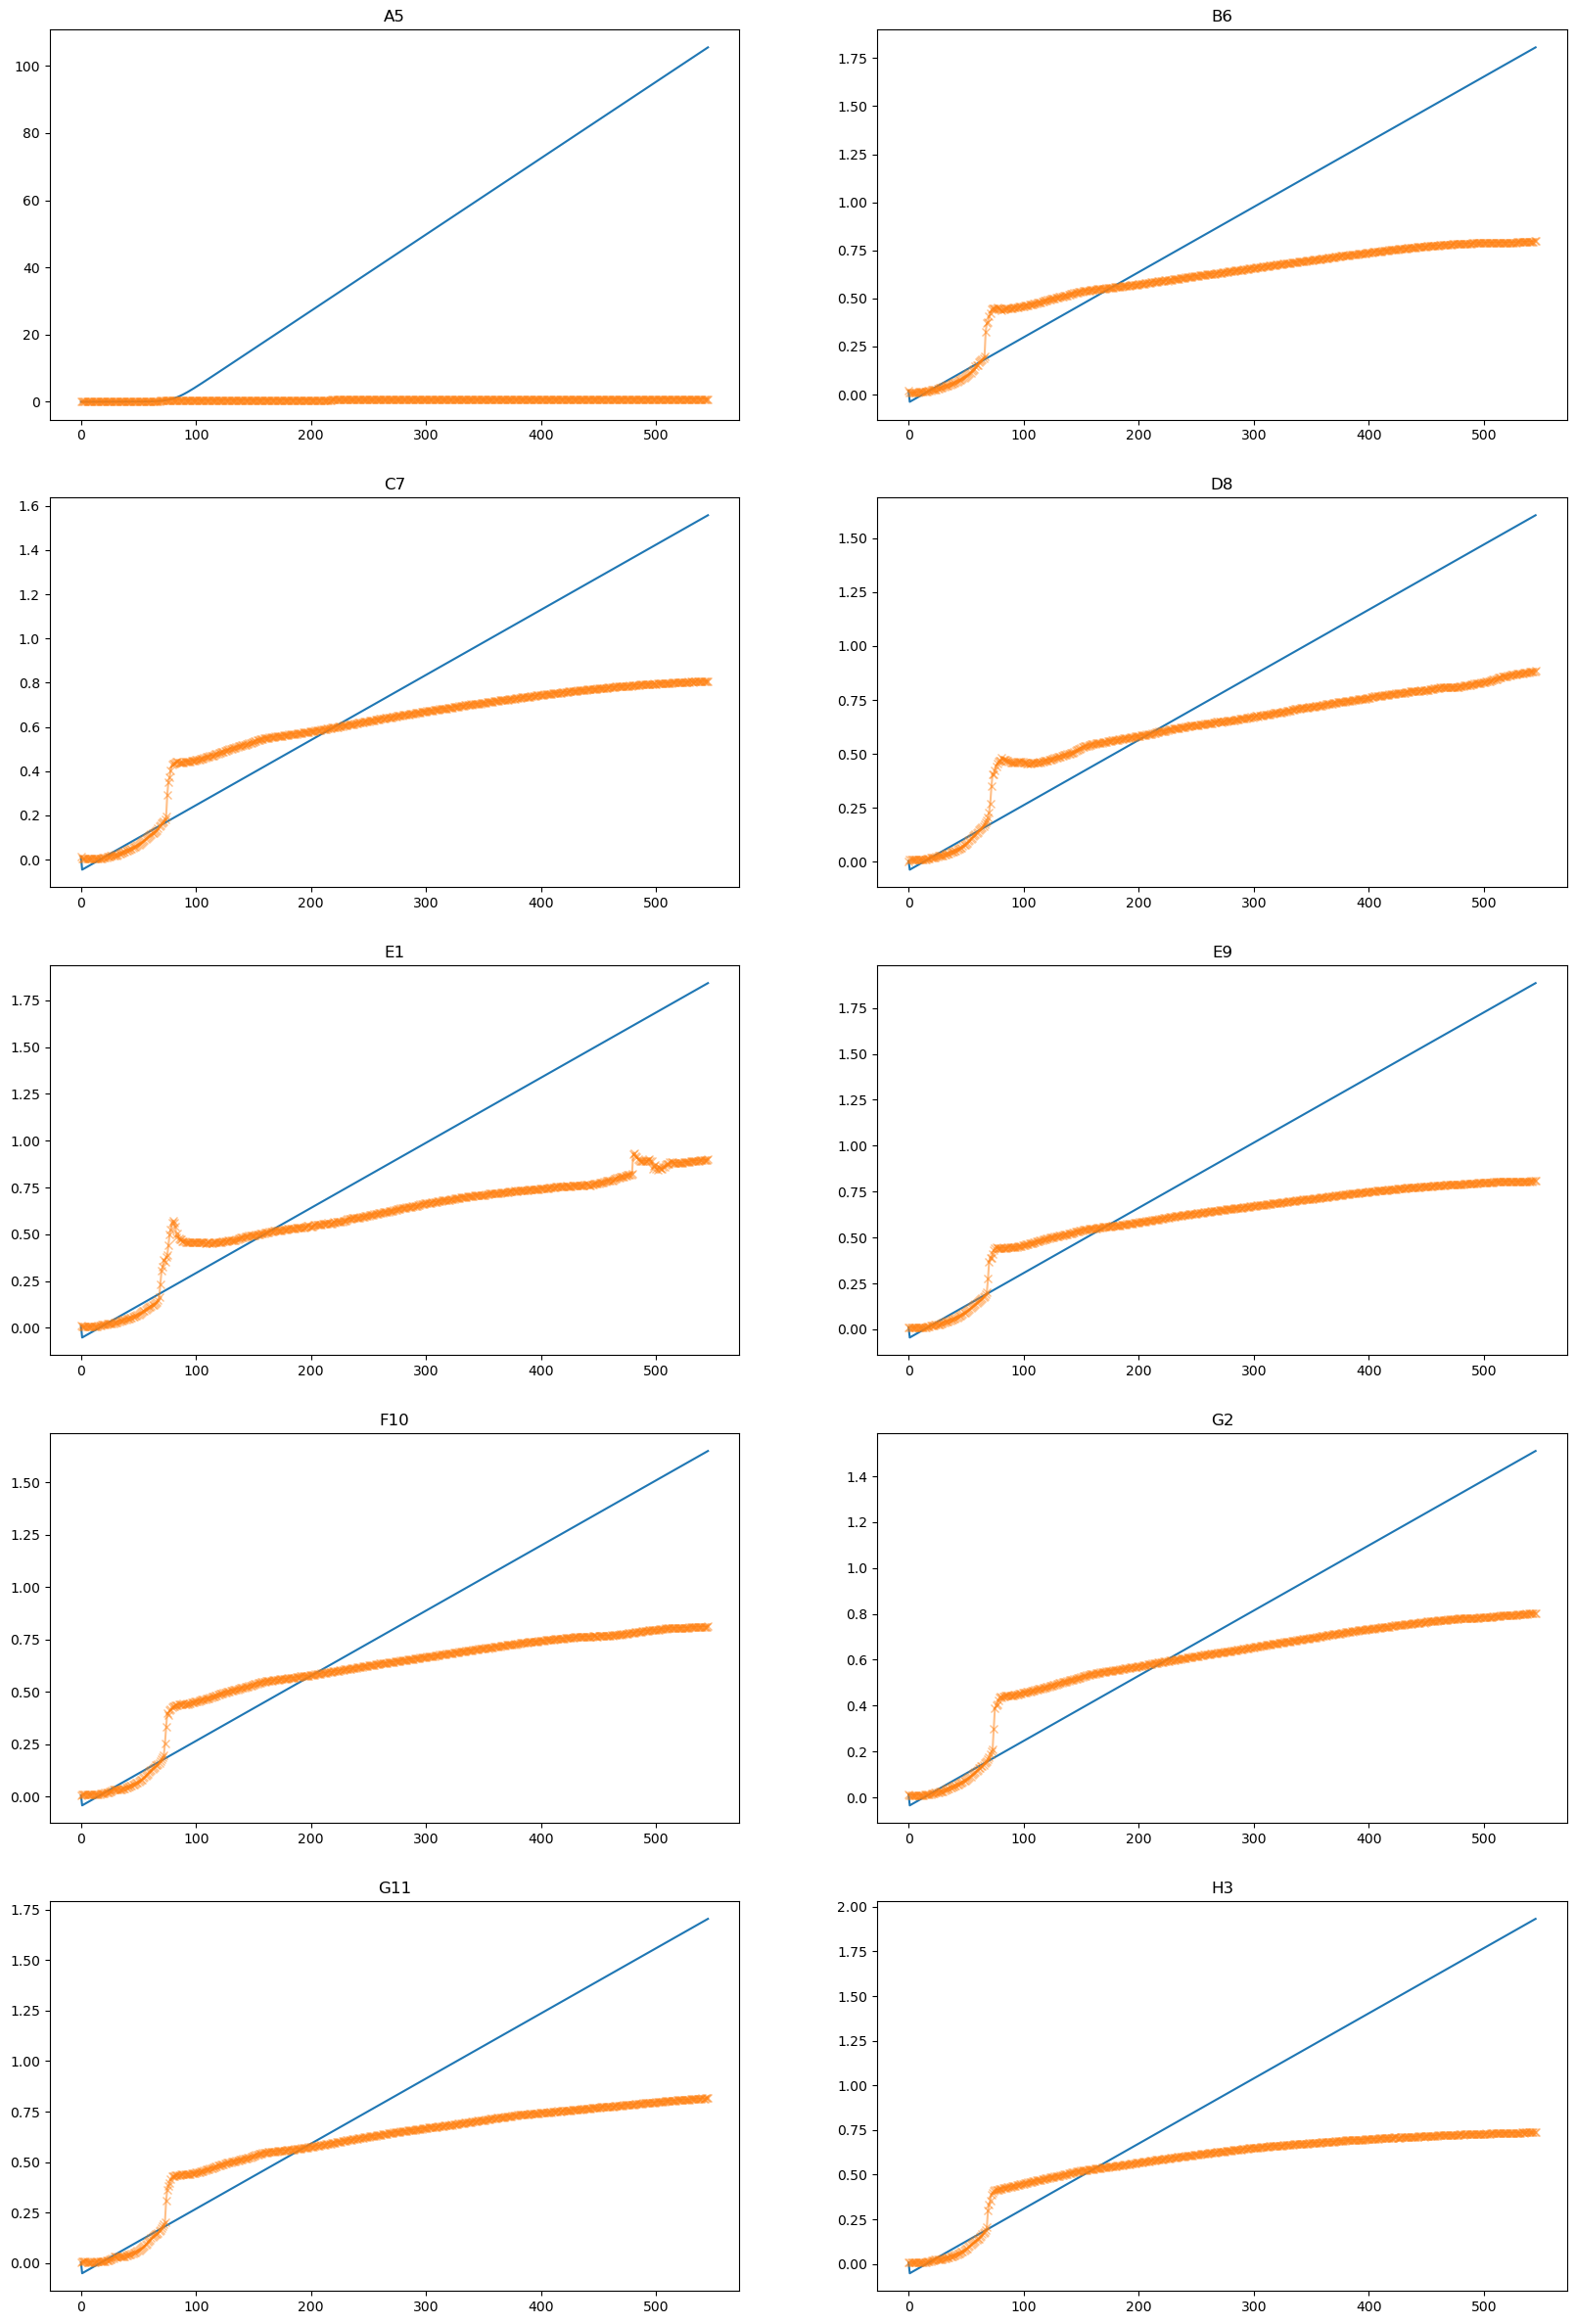

In [384]:
plot_fit(df, new_params)